In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

# Data Generation

In [2]:
# Create sample customer data
customer_data = {
    'customer_id': range(1000),
    'purchase_frequency': np.random.randint(1, 52, 1000),  # purchases per year
    'avg_transaction_value': np.random.normal(150, 50, 1000),  # average spend per visit
    'loyalty_points': np.random.randint(0, 5000, 1000),
    'store_visits': np.random.randint(0, 24, 1000),  # visits per year
    'online_visits': np.random.randint(0, 100, 1000),  # online visits per year
    'returns_rate': np.random.uniform(0, 0.2, 1000),  # return rate percentage
    'skincare_purchases': np.random.randint(0, 30, 1000),
    'makeup_purchases': np.random.randint(0, 40, 1000),
    'fragrance_purchases': np.random.randint(0, 15, 1000)
}

customer_df = pd.DataFrame(customer_data)

# Create sample product data
product_data = {
    'product_id': range(500),
    'price_point': np.random.normal(45, 20, 500),
    'rating': np.random.uniform(3.5, 5, 500),
    'return_rate': np.random.uniform(0, 0.15, 500),
    'reorder_rate': np.random.uniform(0.1, 0.5, 500),
    'shelf_life_months': np.random.randint(12, 36, 500),
    'margin': np.random.uniform(0.3, 0.7, 500),
    'ingredients_count': np.random.randint(5, 50, 500),
    'packaging_size_ml': np.random.normal(100, 30, 500),
    'fragrance_intensity': np.random.uniform(0, 5, 500),
    'application_ease': np.random.uniform(3, 5, 500)
}

product_df = pd.DataFrame(product_data)

# K-Means

In [3]:
def perform_customer_segmentation(df, n_clusters=4):
    """
    Perform K-means clustering on customer data
    """
    # Select features for clustering
    features = [
        'purchase_frequency', 'avg_transaction_value', 'loyalty_points',
        'store_visits', 'online_visits', 'returns_rate',
        'skincare_purchases', 'makeup_purchases', 'fragrance_purchases'
    ]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    
    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    df['customer_segment'] = kmeans.fit_predict(X_scaled)
    
    # Analyze segments
    segment_analysis = df.groupby('customer_segment')[features].mean()
    
    return df, segment_analysis, kmeans.cluster_centers_

# Hierarchical Clustering

In [4]:
def perform_product_clustering(df):
    """
    Perform hierarchical clustering on product data
    """
    features = [
        'price_point', 'rating', 'return_rate', 'reorder_rate',
        'shelf_life_months', 'margin', 'ingredients_count',
        'packaging_size_ml', 'fragrance_intensity', 'application_ease'
    ]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    
    # Create linkage matrix
    linkage_matrix = linkage(X_scaled, method='ward')
    
    # Create clusters
    n_clusters = 5
    df['product_cluster'] = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    # Analyze clusters
    cluster_analysis = df.groupby('product_cluster')[features].mean()
    
    return df, cluster_analysis, linkage_matrix

# PCA

In [5]:
def perform_product_pca(df):
    """
    Perform PCA on product attributes
    """
    features = [
        'price_point', 'rating', 'return_rate', 'reorder_rate',
        'shelf_life_months', 'margin', 'ingredients_count',
        'packaging_size_ml', 'fragrance_intensity', 'application_ease'
    ]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    
    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_scaled)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        pca_result,
        columns=[f'PC{i+1}' for i in range(len(features))]
    )
    
    # Create loadings matrix
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(features))],
        index=features
    )
    
    # Calculate explained variance
    explained_variance = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(len(features))],
        'Explained Variance Ratio': pca.explained_variance_ratio_,
        'Cumulative Variance Ratio': np.cumsum(pca.explained_variance_ratio_)
    })
    
    return pca_df, loadings, explained_variance

# Insights

In [6]:
# Perform analyses
segmented_customers, segment_analysis, cluster_centers = perform_customer_segmentation(customer_df)
clustered_products, product_cluster_analysis, product_linkage = perform_product_clustering(product_df)
product_pca, pca_loadings, pca_variance = perform_product_pca(product_df)

# Example of business insights generation
def generate_customer_segment_insights(segment_analysis):
    """
    Generate business insights from customer segments
    """
    insights = []
    
    for segment in segment_analysis.index:
        segment_data = segment_analysis.loc[segment]
        
        # High value customers
        if segment_data['avg_transaction_value'] > segment_analysis['avg_transaction_value'].mean():
            insights.append(f"Segment {segment} represents high-value customers with average transaction value of ${segment_data['avg_transaction_value']:.2f}")
        
        # Online vs store preference
        if segment_data['online_visits'] > segment_data['store_visits'] * 2:
            insights.append(f"Segment {segment} shows strong preference for online shopping with {segment_data['online_visits']:.0f} online visits vs {segment_data['store_visits']:.0f} store visits")
        
        # Product category preference
        max_category = max(
            ('skincare', segment_data['skincare_purchases']),
            ('makeup', segment_data['makeup_purchases']),
            ('fragrance', segment_data['fragrance_purchases']),
            key=lambda x: x[1]
        )
        insights.append(f"Segment {segment} shows strongest preference for {max_category[0]} with {max_category[1]:.0f} purchases")
    
    return insights

In [7]:
# Generate and print insights
customer_insights = generate_customer_segment_insights(segment_analysis)
print("\nCustomer Segment Insights:")
for insight in customer_insights:
    print(f"- {insight}")

# Print key product cluster characteristics
print("\nProduct Cluster Characteristics:")
for cluster in product_cluster_analysis.index:
    print(f"\nCluster {cluster}:")
    print(f"Average Price: ${product_cluster_analysis.loc[cluster, 'price_point']:.2f}")
    print(f"Average Rating: {product_cluster_analysis.loc[cluster, 'rating']:.2f}")
    print(f"Reorder Rate: {product_cluster_analysis.loc[cluster, 'reorder_rate']:.2%}")

# Print PCA insights
print("\nPCA Insights:")
print("Top 3 Principal Components explain:")
for i in range(3):
    print(f"PC{i+1}: {pca_variance['Explained Variance Ratio'][i]:.2%} of variance")

# Export results to CSV
segmented_customers.to_csv('sephora_customer_segments.csv', index=False)
clustered_products.to_csv('sephora_product_clusters.csv', index=False)


Customer Segment Insights:
- Segment 0 represents high-value customers with average transaction value of $157.32
- Segment 0 shows strong preference for online shopping with 70 online visits vs 9 store visits
- Segment 0 shows strongest preference for makeup with 25 purchases
- Segment 1 shows strong preference for online shopping with 31 online visits vs 10 store visits
- Segment 1 shows strongest preference for makeup with 20 purchases
- Segment 2 represents high-value customers with average transaction value of $156.98
- Segment 2 shows strong preference for online shopping with 37 online visits vs 15 store visits
- Segment 2 shows strongest preference for makeup with 15 purchases
- Segment 3 represents high-value customers with average transaction value of $152.02
- Segment 3 shows strong preference for online shopping with 64 online visits vs 12 store visits
- Segment 3 shows strongest preference for makeup with 19 purchases

Product Cluster Characteristics:

Cluster 1:
Average P

# Visualizations

In [8]:
# Adding visualization functions and business decision implementations

def visualize_customer_segments(df, segment_analysis):
    """
    Create visualizations for customer segments
    """
    # Set up the plotting style
    plt.style.use("seaborn-v0_8-pastel")
    
    # 1. Scatter plot of customer segments
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df['avg_transaction_value'],
        df['purchase_frequency'],
        c=df['customer_segment'],
        cmap='viridis',
        alpha=0.6
    )
    plt.xlabel('Average Transaction Value ($)')
    plt.ylabel('Purchase Frequency (per year)')
    plt.title('Customer Segments: Transaction Value vs Purchase Frequency')
    plt.colorbar(scatter, label='Segment')
    plt.savefig('customer_segments_scatter.png')
    plt.close()
    
    # 2. Radar chart for segment characteristics
    features = ['purchase_frequency', 'avg_transaction_value', 'loyalty_points',
                'store_visits', 'online_visits', 'returns_rate']
    
    # Normalize the features for radar chart
    scaler = StandardScaler()
    segment_analysis_scaled = pd.DataFrame(
        scaler.fit_transform(segment_analysis[features]),
        columns=features,
        index=segment_analysis.index
    )
    
    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for segment in segment_analysis_scaled.index:
        values = segment_analysis_scaled.loc[segment].values
        values = np.concatenate((values, [values[0]]))
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Segment {segment}')
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title('Segment Characteristics Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.savefig('segment_characteristics_radar.png')
    plt.close()

def visualize_product_clusters(df, linkage_matrix):
    """
    Create visualizations for product clusters
    """
    plt.figure(figsize=(15, 10))
    dendrogram(linkage_matrix)
    plt.title('Product Hierarchical Clustering Dendrogram')
    plt.xlabel('Product Index')
    plt.ylabel('Distance')
    plt.savefig('product_clusters_dendrogram.png')
    plt.close()
    
    # Cluster characteristics heatmap
    # need to get rid of product_id colomn before aggregating by clusters
    df2 = df.drop(columns=['product_id'])
    cluster_means = df2.groupby('product_cluster').mean()
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Product Cluster Characteristics')
    plt.savefig('product_clusters_heatmap.png')
    plt.close()

def visualize_pca_results(loadings, explained_variance):
    """
    Create visualizations for PCA results
    """
    # Scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), 
            explained_variance['Explained Variance Ratio'], 
            'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot: Explained Variance by Principal Component')
    plt.savefig('pca_scree_plot.png')
    plt.close()
    
    # Loading plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings.iloc[:, :3], annot=True, cmap='RdBu', center=0)
    plt.title('PCA Loading Heatmap (First 3 Components)')
    plt.savefig('pca_loadings_heatmap.png')
    plt.close()

def implement_business_decisions(customer_df, product_df, segment_analysis, cluster_analysis):
    """
    Implement business decisions based on analysis results
    """
    business_decisions = {
        'marketing_campaigns': {},
        'inventory_recommendations': {},
        'pricing_strategies': {},
        'customer_service': {}
    }
    
    # 1. Marketing Campaign Decisions
    for segment in segment_analysis.index:
        segment_data = segment_analysis.loc[segment]
        
        if segment_data['online_visits'] > segment_data['store_visits'] * 2:
            business_decisions['marketing_campaigns'][f'segment_{segment}'] = {
                'channel': 'digital',
                'focus': 'online_exclusive_products',
                'budget_allocation': 'high_digital_spend',
                'message': 'Exclusive online offers and early access'
            }
        else:
            business_decisions['marketing_campaigns'][f'segment_{segment}'] = {
                'channel': 'omnichannel',
                'focus': 'store_events',
                'budget_allocation': 'balanced_spend',
                'message': 'Join us in store for personalized consultations'
            }
    
    # 2. Inventory Recommendations
    for cluster in cluster_analysis.index:
        cluster_data = cluster_analysis.loc[cluster]
        
        # High margin, high reorder rate products
        if cluster_data['margin'] > 0.5 and cluster_data['reorder_rate'] > 0.3:
            business_decisions['inventory_recommendations'][f'cluster_{cluster}'] = {
                'stock_level': 'high',
                'reorder_point': 'aggressive',
                'display_priority': 'premium_placement',
                'promotion_frequency': 'low'
            }
        else:
            business_decisions['inventory_recommendations'][f'cluster_{cluster}'] = {
                'stock_level': 'moderate',
                'reorder_point': 'standard',
                'display_priority': 'standard_placement',
                'promotion_frequency': 'moderate'
            }
    
    # 3. Pricing Strategy Recommendations
    def calculate_price_elasticity(cluster_data):
        """Simplified price elasticity calculation"""
        return -1 * (cluster_data['reorder_rate'] / cluster_data['price_point'])
    
    for cluster in cluster_analysis.index:
        cluster_data = cluster_analysis.loc[cluster]
        elasticity = calculate_price_elasticity(cluster_data)
        
        if elasticity < -1:  # Elastic demand
            business_decisions['pricing_strategies'][f'cluster_{cluster}'] = {
                'strategy': 'competitive_pricing',
                'discount_approach': 'frequent_small_discounts',
                'price_positioning': 'market_average'
            }
        else:  # Inelastic demand
            business_decisions['pricing_strategies'][f'cluster_{cluster}'] = {
                'strategy': 'premium_pricing',
                'discount_approach': 'rare_deep_discounts',
                'price_positioning': 'premium'
            }
    
    # 4. Customer Service Approach
    for segment in segment_analysis.index:
        segment_data = segment_analysis.loc[segment]
        
        if segment_data['avg_transaction_value'] > segment_analysis['avg_transaction_value'].mean():
            business_decisions['customer_service'][f'segment_{segment}'] = {
                'service_level': 'premium',
                'response_time': 'priority',
                'personalization': 'high',
                'loyalty_program': 'vip_tier'
            }
        else:
            business_decisions['customer_service'][f'segment_{segment}'] = {
                'service_level': 'standard',
                'response_time': 'standard',
                'personalization': 'moderate',
                'loyalty_program': 'standard_tier'
            }
    
    return business_decisions

# Execute visualizations
visualize_customer_segments(customer_df, segment_analysis)
visualize_product_clusters(product_df, product_linkage)
visualize_pca_results(pca_loadings, pca_variance)

# Generate business decisions
business_decisions = implement_business_decisions(
    customer_df, 
    product_df, 
    segment_analysis, 
    product_cluster_analysis
)

# Create business decision report
def generate_business_report(decisions):
    """
    Generate a formatted report of business decisions
    """
    report = pd.DataFrame()
    
    for category, strategies in decisions.items():
        for segment_cluster, details in strategies.items():
            row = pd.Series({
                'Category': category,
                'Segment/Cluster': segment_cluster,
                **details
            })
            report = pd.concat([report, row.to_frame().T], ignore_index=True)
    
    return report

# Generate and save report
business_report = generate_business_report(business_decisions)
business_report.to_csv('sephora_business_decisions.csv', index=False)

print("Analysis complete. Generated files:")
print("1. Customer segment visualizations")
print("2. Product cluster visualizations")
print("3. PCA analysis visualizations")
print("4. Business decisions report")

Analysis complete. Generated files:
1. Customer segment visualizations
2. Product cluster visualizations
3. PCA analysis visualizations
4. Business decisions report


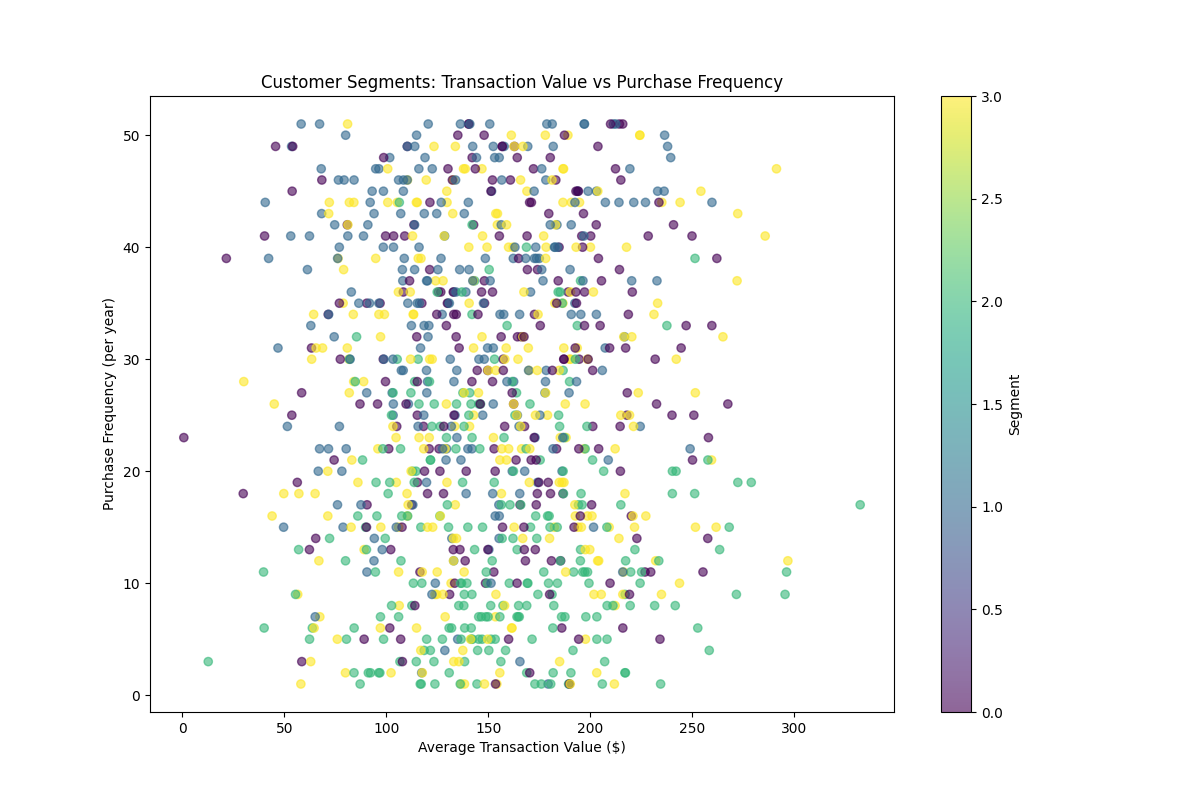

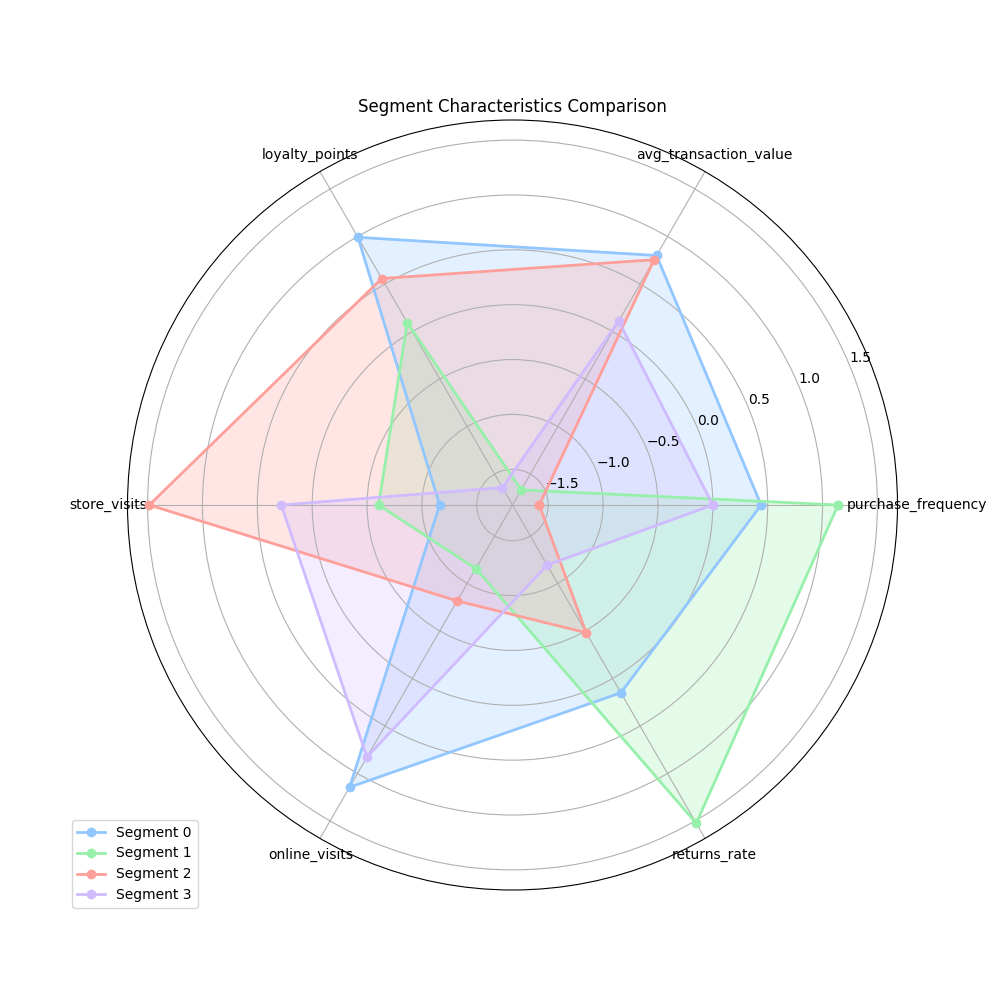

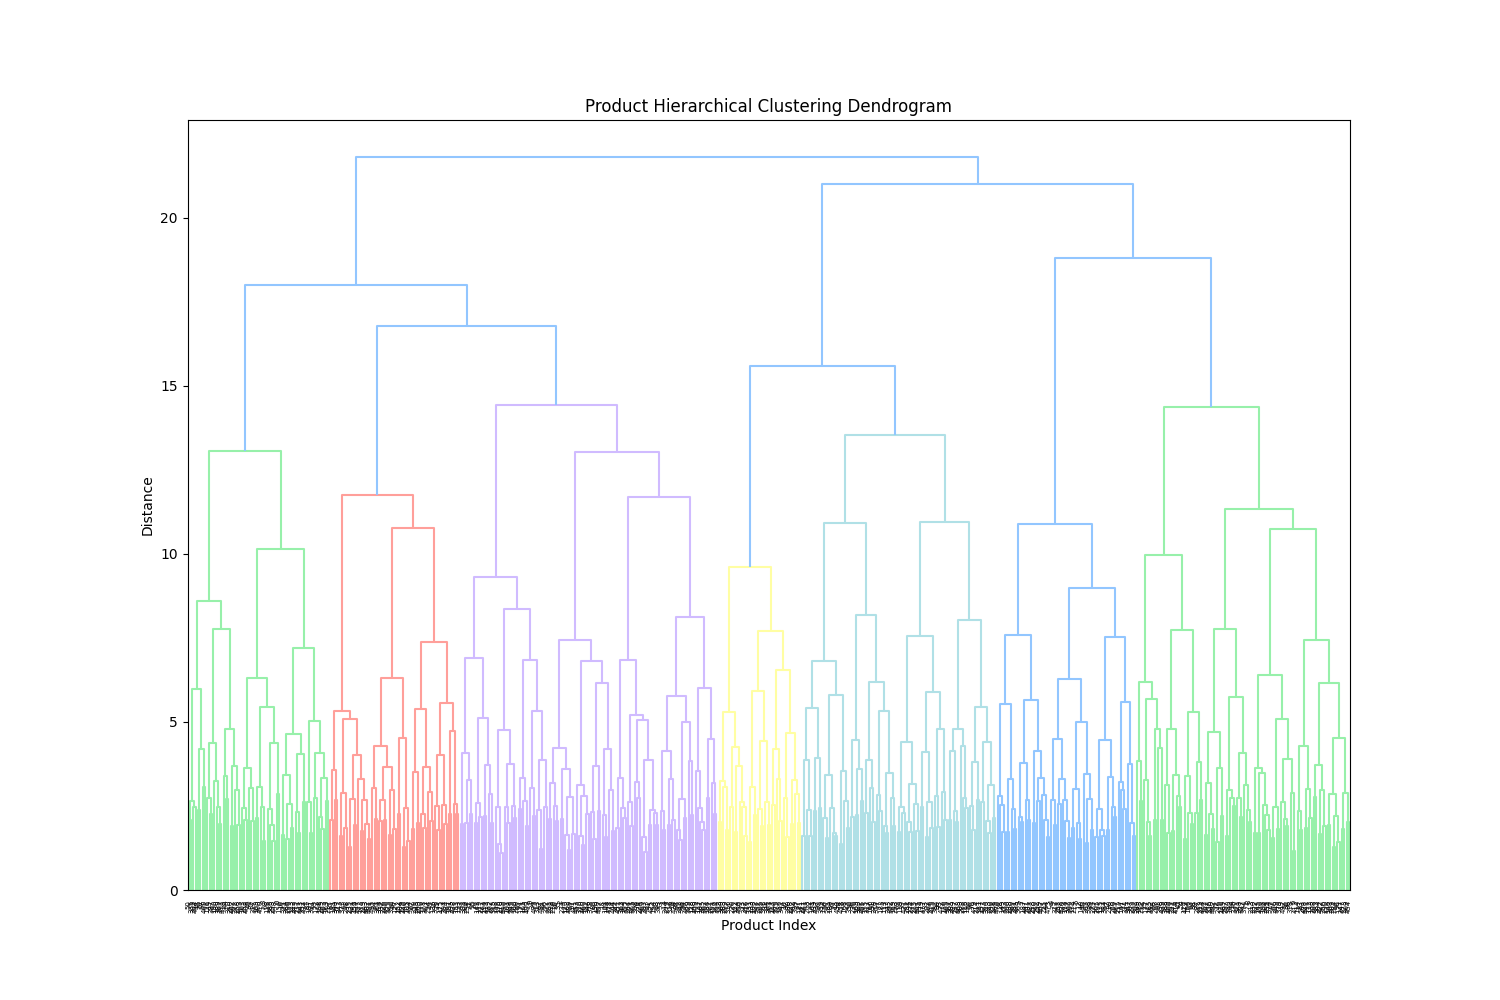

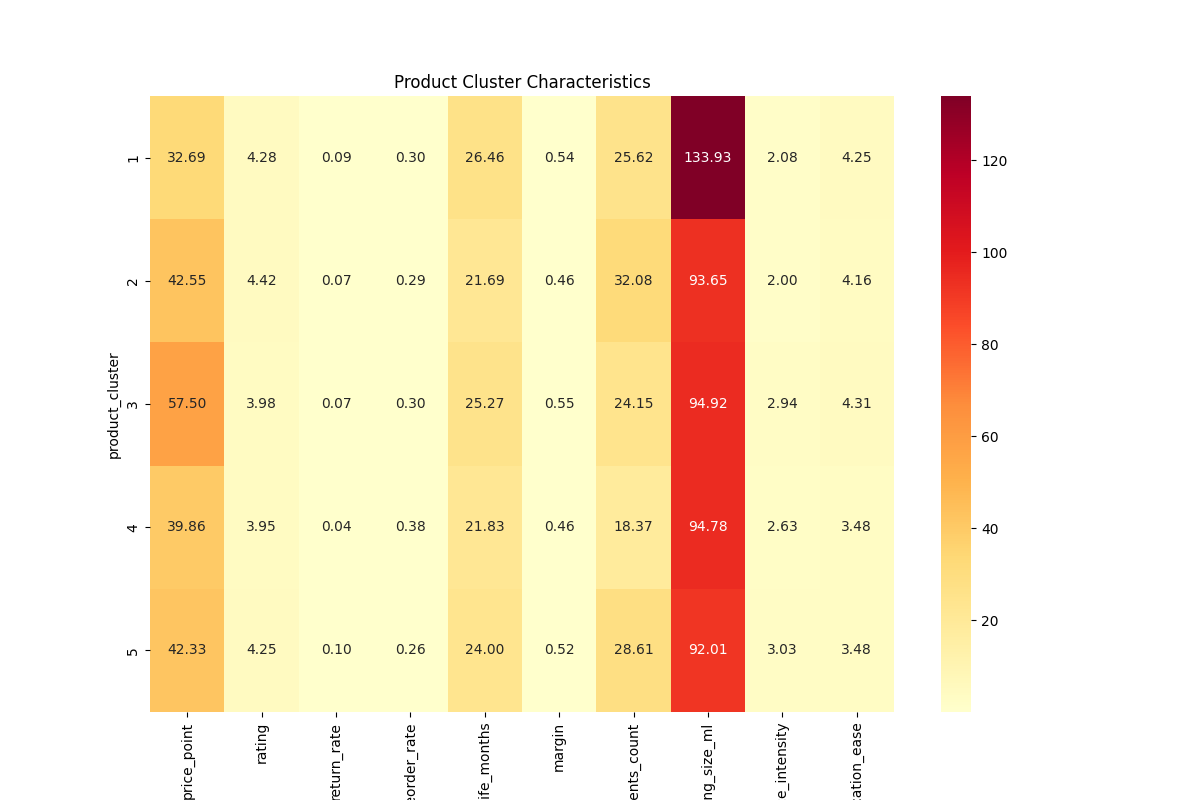

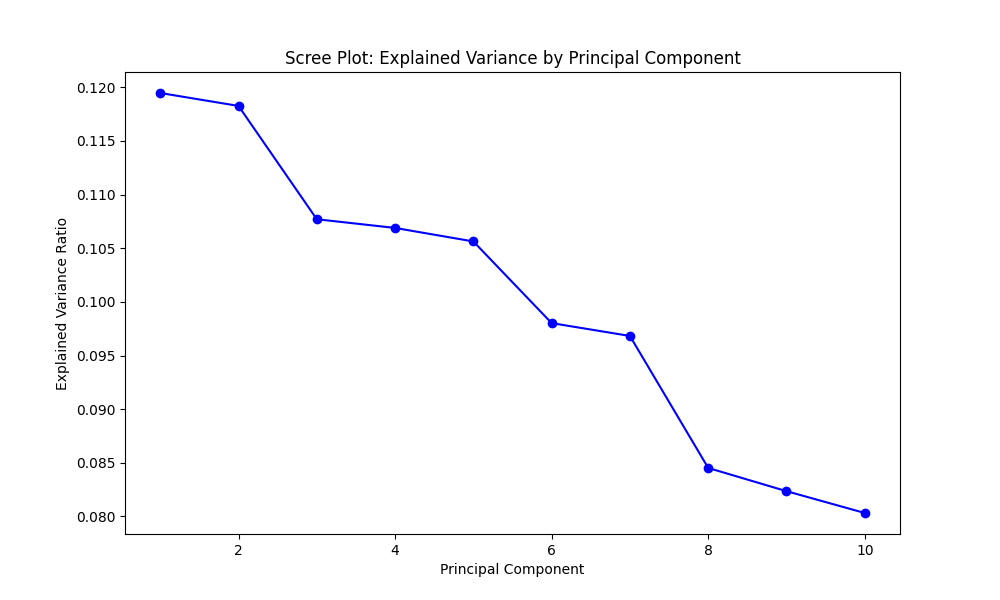

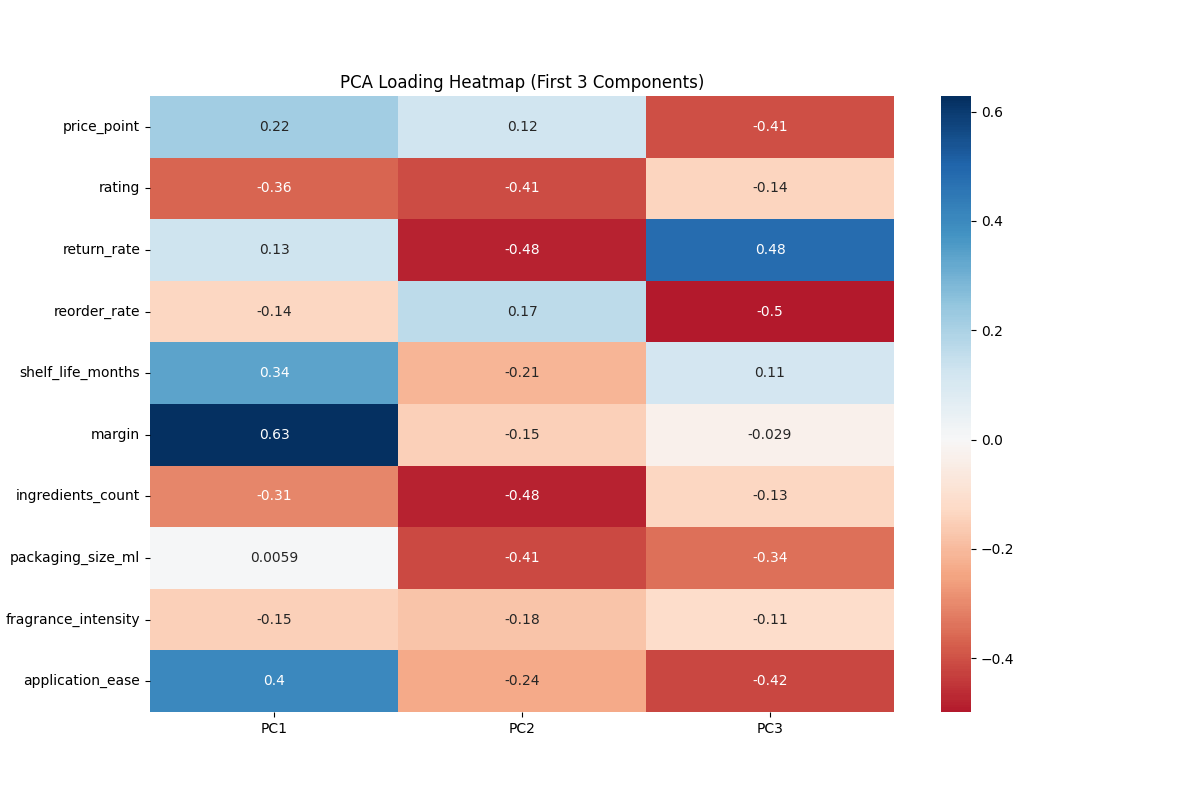

In [9]:
images=['/kaggle/working/customer_segments_scatter.png','/kaggle/working/segment_characteristics_radar.png',
       '/kaggle/working/product_clusters_dendrogram.png','/kaggle/working/product_clusters_heatmap.png',
        '/kaggle/working/pca_scree_plot.png', '/kaggle/working/pca_loadings_heatmap.png'
       ]
for imageName in images:
    display(Image(filename=imageName))

In [10]:
# Sephora Customer Segments
pd.read_csv('/kaggle/working/sephora_customer_segments.csv')

,customer_id,purchase_frequency,avg_transaction_value,loyalty_points,store_visits,online_visits,returns_rate,skincare_purchases,makeup_purchases,fragrance_purchases,customer_segment
0,0,41,249.814935,3880,22,93,0.148604,21,1,12,0
1,1,47,122.462611,2895,9,72,0.169604,1,0,0,1
2,2,33,193.558348,493,23,2,0.110944,5,10,7,2
3,3,9,174.262470,3453,15,98,0.096624,13,9,6,2
4,4,34,133.022611,4218,2,88,0.103053,15,11,13,0
...,...,...,...,...,...,...,...,...,...,...,...
995,995,13,136.045216,4617,1,47,0.115484,23,20,6,0
996,996,26,145.949960,3568,11,79,0.136858,26,37,10,0
997,997,30,103.196470,2918,13,12,0.108853,5,10,6,1
998,998,13,221.823834,4072,8,26,0.125697,13,12,8,2


In [11]:
# Sephora Product Clusters
pd.read_csv('/kaggle/working/sephora_product_clusters.csv')

,product_id,price_point,rating,return_rate,reorder_rate,shelf_life_months,margin,ingredients_count,packaging_size_ml,fragrance_intensity,application_ease,product_cluster
0,0,73.415306,4.018962,0.146300,0.262418,27,0.406327,7,132.220517,0.591430,4.664275,1
1,1,29.371773,4.798740,0.008695,0.251965,17,0.470933,44,90.212903,4.297061,4.459977,2
2,2,13.448979,4.722525,0.123716,0.340110,18,0.505561,43,73.941503,0.251754,4.577907,2
3,3,29.521670,4.749621,0.135197,0.302711,28,0.496384,14,111.218025,2.315828,3.703533,1
4,4,50.015326,3.645465,0.008545,0.487202,28,0.530072,40,121.748917,0.530668,3.447372,4
...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,60.687372,3.797919,0.016792,0.207143,34,0.334631,48,83.561829,0.605229,3.707176,2
496,496,66.525273,4.439436,0.113569,0.301541,16,0.344769,28,75.642952,1.411264,4.725197,2
497,497,30.187226,4.639930,0.082242,0.321415,34,0.632339,43,142.227285,0.259334,3.125438,1
498,498,17.439237,4.233659,0.005419,0.431097,27,0.559624,15,87.785523,0.881006,3.330705,4


In [12]:
# Sephora Business Decisions
pd.read_csv('/kaggle/working/sephora_business_decisions.csv')

,Category,Segment/Cluster,channel,focus,budget_allocation,message,stock_level,reorder_point,display_priority,promotion_frequency,strategy,discount_approach,price_positioning,service_level,response_time,personalization,loyalty_program
0,marketing_campaigns,segment_0,digital,online_exclusive_products,high_digital_spend,Exclusive online offers and early access,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,marketing_campaigns,segment_1,digital,online_exclusive_products,high_digital_spend,Exclusive online offers and early access,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,marketing_campaigns,segment_2,digital,online_exclusive_products,high_digital_spend,Exclusive online offers and early access,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,marketing_campaigns,segment_3,digital,online_exclusive_products,high_digital_spend,Exclusive online offers and early access,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,inventory_recommendations,cluster_1,NaN,NaN,NaN,NaN,high,aggressive,premium_placement,low,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,inventory_recommendations,cluster_2,NaN,NaN,NaN,NaN,moderate,standard,standard_placement,moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,inventory_recommendations,cluster_3,NaN,NaN,NaN,NaN,moderate,standard,standard_placement,moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,inventory_recommendations,cluster_4,NaN,NaN,NaN,NaN,moderate,standard,standard_placement,moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,inventory_recommendations,cluster_5,NaN,NaN,NaN,NaN,moderate,standard,standard_placement,moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,pricing_strategies,cluster_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,premium_pricing,rare_deep_discounts,premium,NaN,NaN,NaN,NaN
